# Test plane extraction for a single point cloud

In [40]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.general as general
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
from planeslam.extraction import scan_from_clusters
import planeslam.io as io

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Read Point Cloud from pcd file

In [41]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_0.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

[Open3D WARNING] Read PCD failed: unable to open file: c:\Users\adamd\NAVLAB\LiDAR SLAM\planeslam\notebooks\..\data\airsim\blocks_0.pcd


In [42]:
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PCs = io.read_lidar_bin(binpath)
P = PCs[0]

In [43]:
# Convert points to ENU
#P = general.NED_to_ENU(P)

# Downsample the points
P = general.downsample(P, factor=2, axis=0)

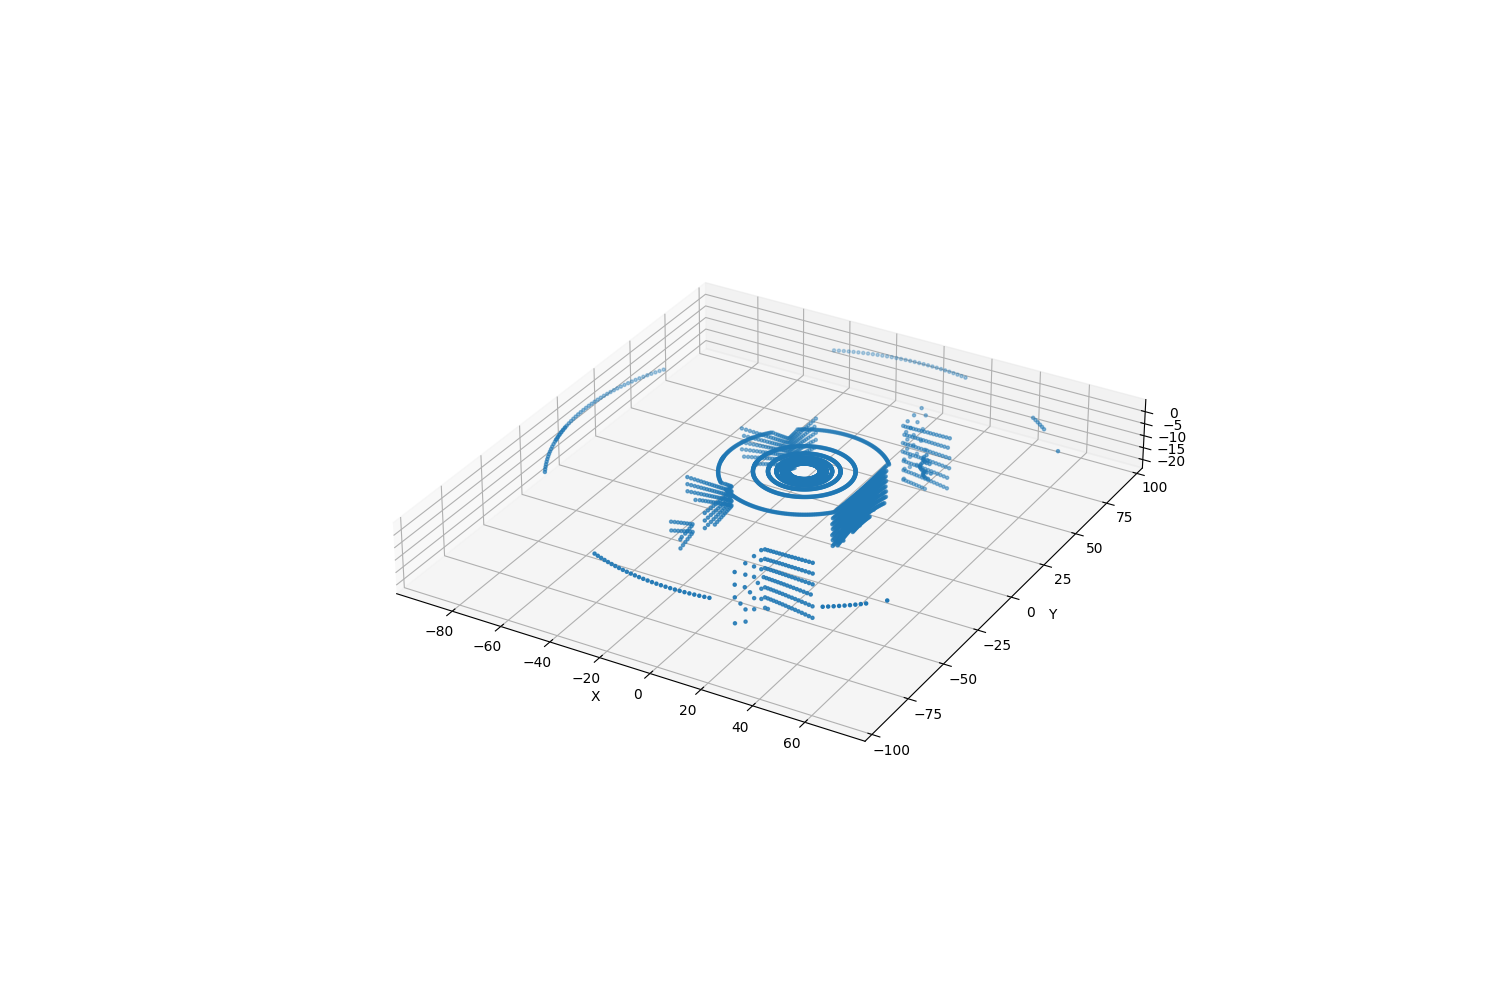

In [44]:
# Plot the points
ax = general.plot_3D_setup(P)
ax.scatter3D(P[:,0], P[:,1], P[:,2], marker='.')  

Cluster the points

In [48]:
# Create the mesh
start_time = time.time()
mesh = LidarMesh(P)
print("elapsed time: ", time.time() - start_time)
start_time = time.time()
mesh.prune(edge_len_lim=10)
print("elapsed time: ", time.time() - start_time)
# Cluster the mesh with graph search
start_time = time.time()
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.03998446464538574
elapsed time:  0.10300445556640625
elapsed time:  0.03799772262573242


In [49]:
%lprun -f cluster_mesh_graph_search cluster_mesh_graph_search(mesh)

Timer unit: 1e-07 s

Total time: 0.131335 s
File: c:\users\adamd\navlab\lidar slam\planeslam\planeslam\clustering.py
Function: cluster_mesh_graph_search at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def cluster_mesh_graph_search(mesh, normal_match_thresh=0.866, min_cluster_size=20):
     9                                               """Cluster mesh with graph search
    10                                               
    11                                               Parameters
    12                                               ----------
    13                                               mesh : LidarMesh
    14                                                   Mesh object to cluster
    15                                               normal_match_thresh : float
    16                                                   Norm difference threshold to cluster triangles together (default value corresponds

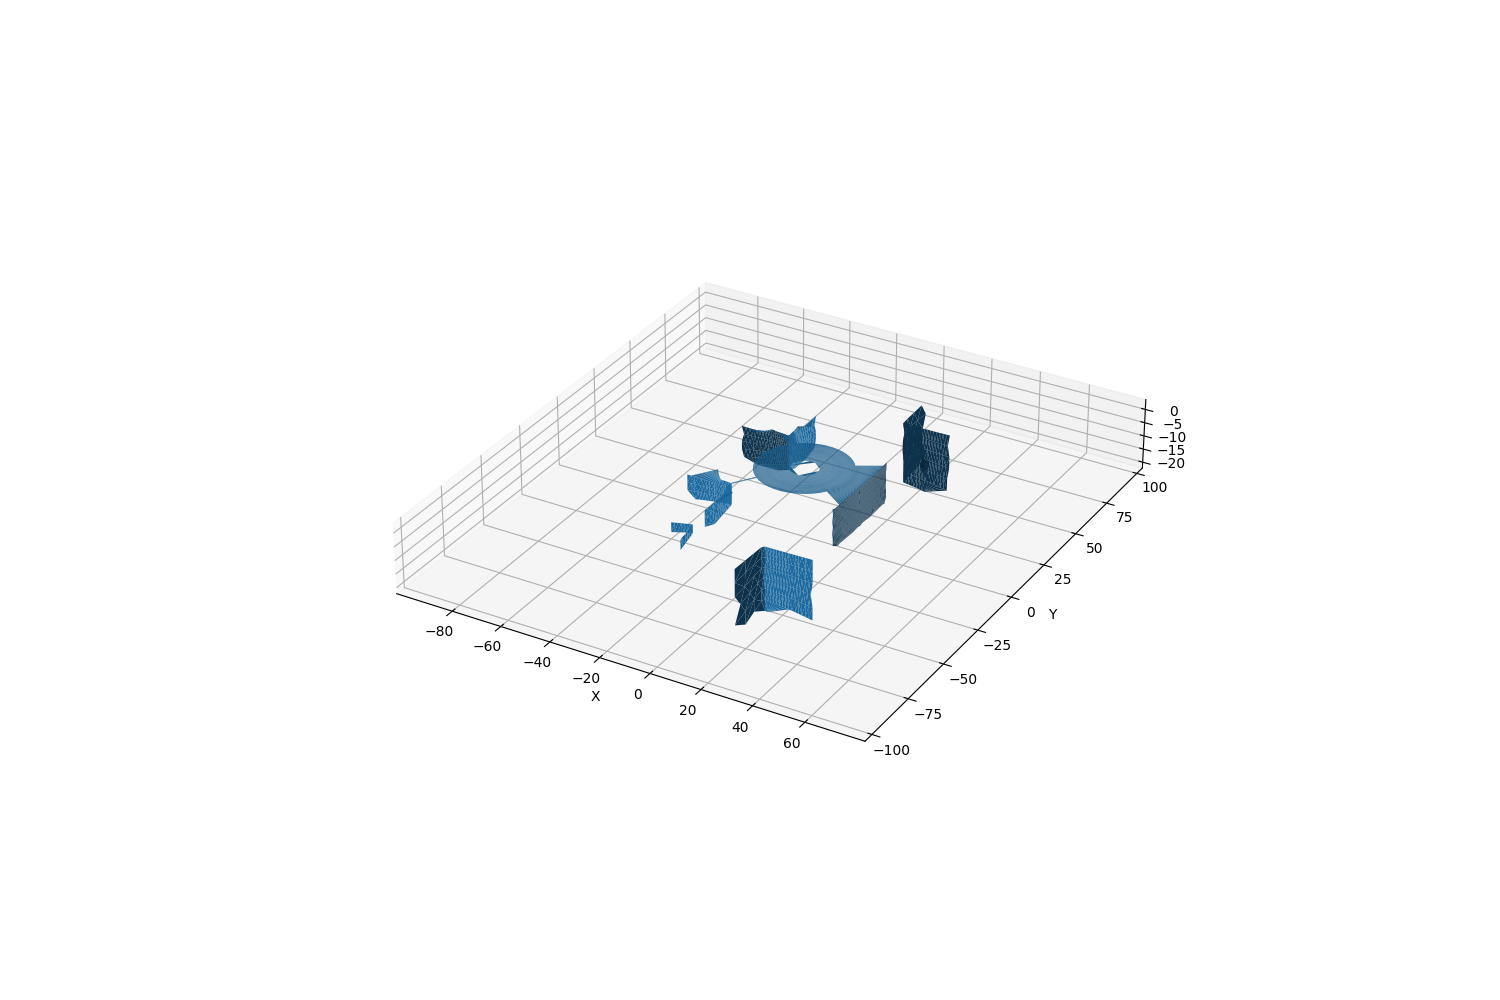

In [50]:
# Plot mesh
ax = general.plot_3D_setup(P)

ax.plot_trisurf(P[:,0], P[:,1], P[:,2], triangles=mesh.DT.simplices)

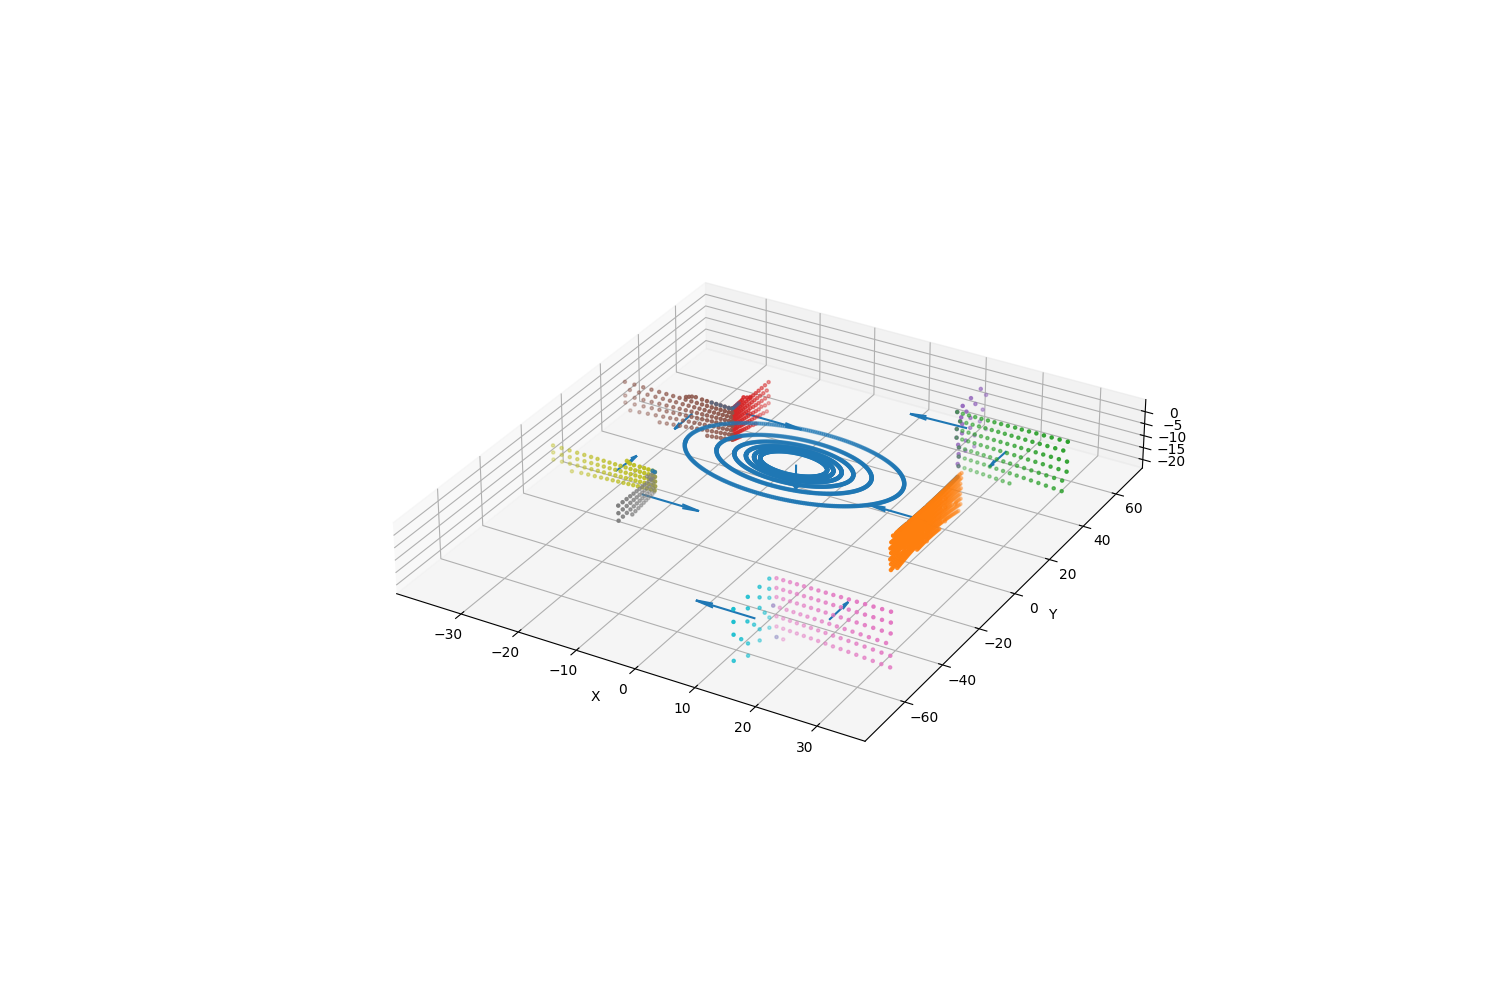

In [51]:
# Plot clusters
ax = general.plot_3D_setup(P)

cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]

for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(i), marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

Extract planes

In [61]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

In [62]:
normals = mesh.compute_normals()
normals[clusters[1]]

array([[-1., -0., -0.],
       [-1.,  0.,  0.],
       [-1.,  0., -0.],
       ...,
       [-1., -0.,  0.],
       [-1., -0.,  0.],
       [-1.,  0.,  0.]])

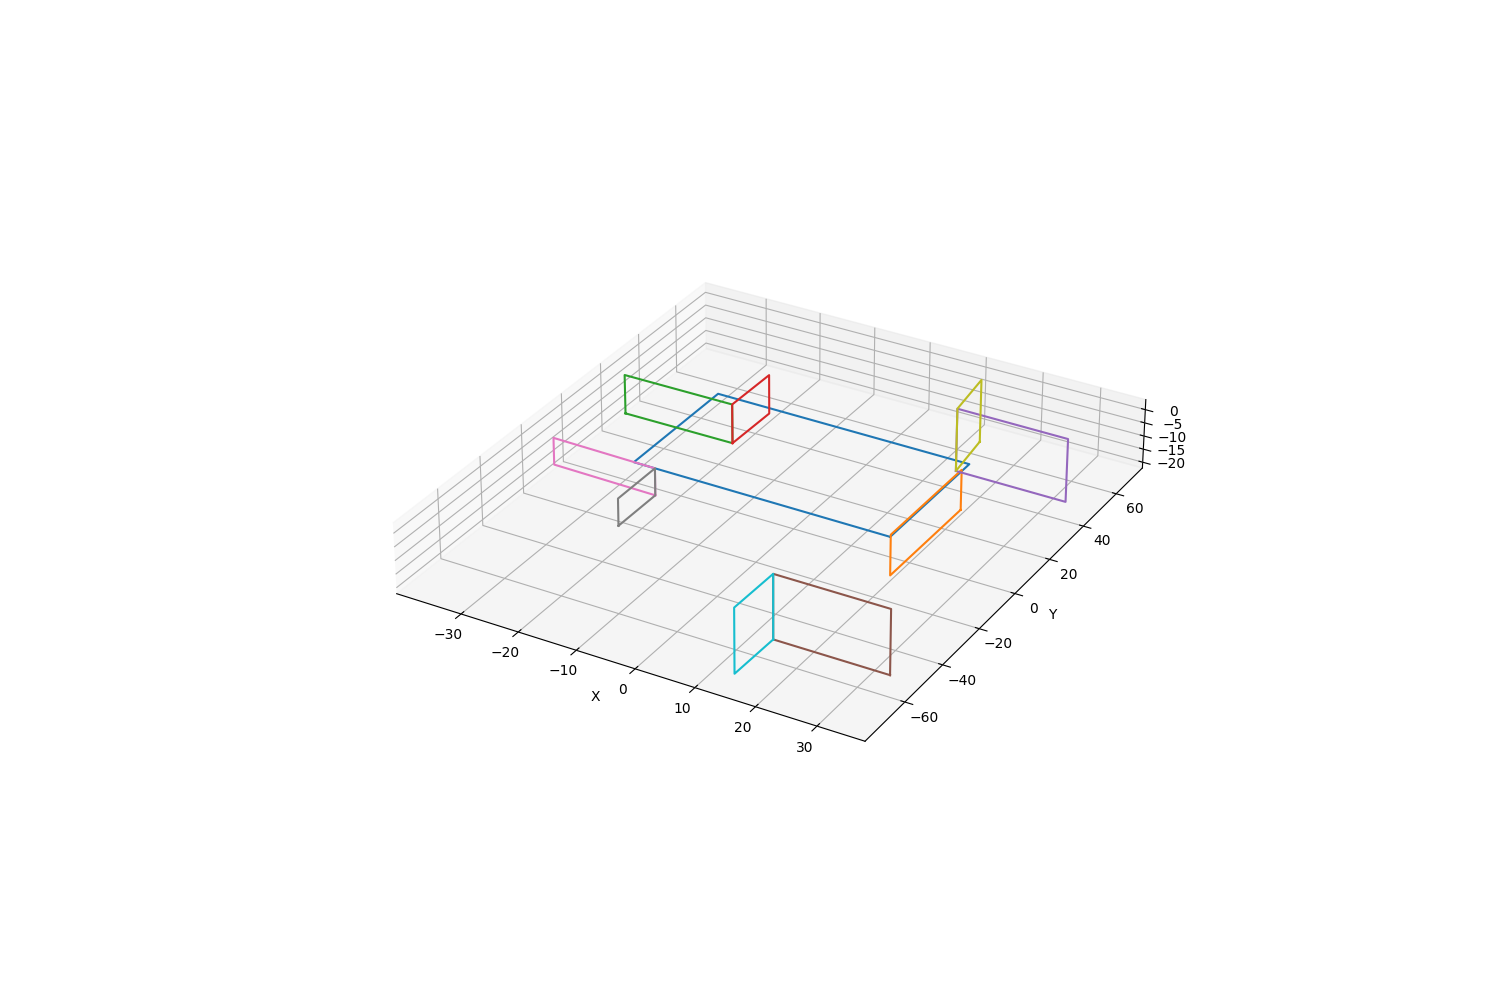

In [63]:
ax = general.plot_3D_setup(P)
scan.plot(ax, show_normals=False)

In [56]:
i = 1
c = clusters[i]
n = avg_normals[i][:,None]
cluster_pts = mesh_cluster_pts(mesh, c)  # Extract points from cluster

In [57]:
cluster_pts

array([[ 23.10000038,  -6.19521713, -11.66477585],
       [ 23.10000038,  -5.70033312, -11.60459328],
       [ 23.10000038,  -5.21034241, -11.5496664 ],
       ...,
       [ 23.10000038,  16.56019402,   2.98734665],
       [ 23.10000038,  17.27317429,   3.03161931],
       [ 23.14172363,  18.04043198,   3.08404636]])

In [58]:
from planeslam.extraction import bd_plane_from_pts
plane_pts = bd_plane_from_pts(cluster_pts, n)

In [59]:
plane_pts

array([[ 23.11671786,  18.04042704, -11.66477576],
       [ 23.0972525 , -20.84632768, -11.66477594],
       [ 23.097114  , -20.84632761,   3.19003811],
       [ 23.11657937,  18.04042711,   3.19003829]])